<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB3] - Training monitoring
<!-- DESC --> Episode 3 : Monitoring, analysis and check points during a training session
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - **Understand** what happens during the **training** process
  - Implement **monitoring**, **backup** and **recovery** solutions
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

## What we're going to do :

 - Monitoring and understanding our model training 
 - Add recovery points
 - Analyze the results 
 - Restore and run recovery points

## Step 1 - Import and init
### 1.1 - Python stuffs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix
from skimage import io, transform, color

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB3.001'
datasets_dir = pwk.init('GTSRB3', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB3_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.12
Notebook id          : GTSRB3
Run time             : Tuesday 09 February 2021, 18:45:41
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB3_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB3_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 24x24 dataset, with 5 epochs and a scale of 1, need  3'30 on a CPU laptop.

In [2]:
enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'
dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 5
scale        = 1

# enhanced_dir = './data'

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)


Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:00 246ms)


## Step 3 - Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


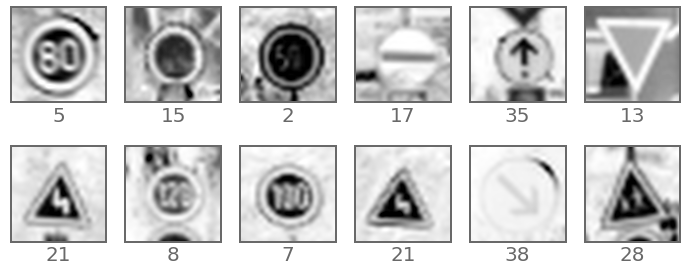

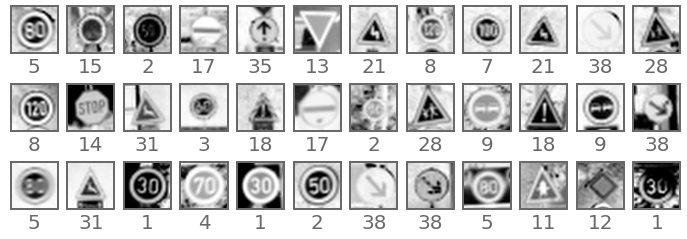

In [5]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

pwk.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
pwk.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models... 

In [6]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard).  

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [7]:
pwk.mkdir(run_dir + '/models')
pwk.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + pwk.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

print(f'To run tensorboard, use :  --logdir {run_dir}/logs')

To run tensorboard, use :  --logdir ./run/GTSRB3_done/logs


## Step 6 - Train the model
**Get the shape of my data :**

In [8]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [9]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :**  
Note: The training curve is visible in real time with Tensorboard (see step  5)

In [10]:
pwk.chrono_start()

# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
# Note: To be faster in our example, we can take only 2000 values
#
history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

pwk.chrono_show()

Epoch 1/5


  1/613 [..............................] - ETA: 29:12 - loss: 3.7791 - accuracy: 0.0312

  3/613 [..............................] - ETA: 1:29 - loss: 3.7370 - accuracy: 0.0321 

 21/613 [>.............................] - ETA: 10s - loss: 3.6524 - accuracy: 0.0568 

 39/613 [>.............................] - ETA: 5s - loss: 3.6200 - accuracy: 0.0582 

 57/613 [=>............................] - ETA: 4s - loss: 3.5922 - accuracy: 0.0622

 76/613 [==>...........................] - ETA: 3s - loss: 3.5583 - accuracy: 0.0693

 95/613 [===>..........................] - ETA: 3s - loss: 3.5158 - accuracy: 0.0801

114/613 [====>.........................] - ETA: 2s - loss: 3.4639 - accuracy: 0.0937

133/613 [=====>........................] - ETA: 2s - loss: 3.4059 - accuracy: 0.1088

152/613 [======>.......................] - ETA: 2s - loss: 3.3432 - accuracy: 0.1246

171/613 [=======>......................] - ETA: 1s - loss: 3.2774 - accuracy: 0.1408

190/613 [========>.....................] - ETA: 1s - loss: 3.2108 - accuracy: 0.1571

209/613 [=========>....................] - ETA: 1s - loss: 3.1458 - accuracy: 0.1729

229/613 [==========>...................] - ETA: 1s - loss: 3.0792 - accuracy: 0.1892

249/613 [===========>..................] - ETA: 1s - loss: 3.0146 - accuracy: 0.2051

269/613 [============>.................] - ETA: 1s - loss: 2.9519 - accuracy: 0.2205

289/613 [=============>................] - ETA: 1s - loss: 2.8915 - accuracy: 0.2354

309/613 [==============>...............] - ETA: 1s - loss: 2.8338 - accuracy: 0.2497

329/613 [===============>..............] - ETA: 1s - loss: 2.7785 - accuracy: 0.2633

349/613 [================>.............] - ETA: 0s - loss: 2.7255 - accuracy: 0.2765

369/613 [=================>............] - ETA: 0s - loss: 2.6747 - accuracy: 0.2892

389/613 [==================>...........] - ETA: 0s - loss: 2.6260 - accuracy: 0.3014

409/613 [===================>..........] - ETA: 0s - loss: 2.5792 - accuracy: 0.3132

429/613 [===================>..........] - ETA: 0s - loss: 2.5343 - accuracy: 0.3245

449/613 [====================>.........] - ETA: 0s - loss: 2.4913 - accuracy: 0.3353

469/613 [=====================>........] - ETA: 0s - loss: 2.4500 - accuracy: 0.3458

489/613 [======================>.......] - ETA: 0s - loss: 2.4104 - accuracy: 0.3558

509/613 [=======================>......] - ETA: 0s - loss: 2.3722 - accuracy: 0.3655

529/613 [========================>.....] - ETA: 0s - loss: 2.3355 - accuracy: 0.3749

549/613 [=========================>....] - ETA: 0s - loss: 2.3002 - accuracy: 0.3840

569/613 [==========================>...] - ETA: 0s - loss: 2.2661 - accuracy: 0.3927

589/613 [===========================>..] - ETA: 0s - loss: 2.2333 - accuracy: 0.4011

609/613 [============================>.] - ETA: 0s - loss: 2.2017 - accuracy: 0.4093

613/613 [==============================] - 6s 5ms/step - loss: 2.1940 - accuracy: 0.4113 - val_loss: 0.4607 - val_accuracy: 0.8895


Epoch 2/5
  1/613 [..............................] - ETA: 1s - loss: 0.3488 - accuracy: 0.9062

 21/613 [>.............................] - ETA: 1s - loss: 0.3422 - accuracy: 0.9067

 41/613 [=>............................] - ETA: 1s - loss: 0.3335 - accuracy: 0.9096

 61/613 [=>............................] - ETA: 1s - loss: 0.3312 - accuracy: 0.9089

 81/613 [==>...........................] - ETA: 1s - loss: 0.3299 - accuracy: 0.9086

101/613 [===>..........................] - ETA: 1s - loss: 0.3294 - accuracy: 0.9080

121/613 [====>.........................] - ETA: 1s - loss: 0.3289 - accuracy: 0.9077

141/613 [=====>........................] - ETA: 1s - loss: 0.3278 - accuracy: 0.9076

161/613 [======>.......................] - ETA: 1s - loss: 0.3263 - accuracy: 0.9078

181/613 [=======>......................] - ETA: 1s - loss: 0.3243 - accuracy: 0.9082

201/613 [========>.....................] - ETA: 1s - loss: 0.3222 - accuracy: 0.9086

221/613 [=========>....................] - ETA: 1s - loss: 0.3201 - accuracy: 0.9091

241/613 [==========>...................] - ETA: 0s - loss: 0.3180 - accuracy: 0.9096

261/613 [===========>..................] - ETA: 0s - loss: 0.3160 - accuracy: 0.9101

281/613 [============>.................] - ETA: 0s - loss: 0.3142 - accuracy: 0.9106

301/613 [=============>................] - ETA: 0s - loss: 0.3123 - accuracy: 0.9111

321/613 [==============>...............] - ETA: 0s - loss: 0.3104 - accuracy: 0.9116

341/613 [===============>..............] - ETA: 0s - loss: 0.3086 - accuracy: 0.9121

361/613 [================>.............] - ETA: 0s - loss: 0.3069 - accuracy: 0.9126

381/613 [=================>............] - ETA: 0s - loss: 0.3050 - accuracy: 0.9131

401/613 [==================>...........] - ETA: 0s - loss: 0.3032 - accuracy: 0.9136

421/613 [===================>..........] - ETA: 0s - loss: 0.3014 - accuracy: 0.9140

441/613 [====================>.........] - ETA: 0s - loss: 0.2996 - accuracy: 0.9145

461/613 [=====================>........] - ETA: 0s - loss: 0.2978 - accuracy: 0.9150

481/613 [======================>.......] - ETA: 0s - loss: 0.2960 - accuracy: 0.9155

501/613 [=======================>......] - ETA: 0s - loss: 0.2942 - accuracy: 0.9160

521/613 [========================>.....] - ETA: 0s - loss: 0.2925 - accuracy: 0.9164

541/613 [=========================>....] - ETA: 0s - loss: 0.2908 - accuracy: 0.9169

561/613 [==========================>...] - ETA: 0s - loss: 0.2892 - accuracy: 0.9173

581/613 [===========================>..] - ETA: 0s - loss: 0.2875 - accuracy: 0.9178

601/613 [============================>.] - ETA: 0s - loss: 0.2859 - accuracy: 0.9182

613/613 [==============================] - 2s 3ms/step - loss: 0.2849 - accuracy: 0.9185 - val_loss: 0.3058 - val_accuracy: 0.9223


Epoch 3/5
  1/613 [..............................] - ETA: 1s - loss: 0.0892 - accuracy: 1.0000

 21/613 [>.............................] - ETA: 1s - loss: 0.1596 - accuracy: 0.9549

 41/613 [=>............................] - ETA: 1s - loss: 0.1642 - accuracy: 0.9529

 61/613 [=>............................] - ETA: 1s - loss: 0.1640 - accuracy: 0.9520

 81/613 [==>...........................] - ETA: 1s - loss: 0.1635 - accuracy: 0.9519

101/613 [===>..........................] - ETA: 1s - loss: 0.1623 - accuracy: 0.9522

121/613 [====>.........................] - ETA: 1s - loss: 0.1610 - accuracy: 0.9526

141/613 [=====>........................] - ETA: 1s - loss: 0.1599 - accuracy: 0.9530

161/613 [======>.......................] - ETA: 1s - loss: 0.1589 - accuracy: 0.9533

181/613 [=======>......................] - ETA: 1s - loss: 0.1579 - accuracy: 0.9537

201/613 [========>.....................] - ETA: 1s - loss: 0.1569 - accuracy: 0.9540

221/613 [=========>....................] - ETA: 1s - loss: 0.1559 - accuracy: 0.9542

241/613 [==========>...................] - ETA: 0s - loss: 0.1553 - accuracy: 0.9544

261/613 [===========>..................] - ETA: 0s - loss: 0.1547 - accuracy: 0.9545

281/613 [============>.................] - ETA: 0s - loss: 0.1543 - accuracy: 0.9547

301/613 [=============>................] - ETA: 0s - loss: 0.1538 - accuracy: 0.9549

321/613 [==============>...............] - ETA: 0s - loss: 0.1532 - accuracy: 0.9550

341/613 [===============>..............] - ETA: 0s - loss: 0.1527 - accuracy: 0.9552

361/613 [================>.............] - ETA: 0s - loss: 0.1522 - accuracy: 0.9554

381/613 [=================>............] - ETA: 0s - loss: 0.1516 - accuracy: 0.9555

401/613 [==================>...........] - ETA: 0s - loss: 0.1511 - accuracy: 0.9557

421/613 [===================>..........] - ETA: 0s - loss: 0.1507 - accuracy: 0.9558

441/613 [====================>.........] - ETA: 0s - loss: 0.1502 - accuracy: 0.9560

461/613 [=====================>........] - ETA: 0s - loss: 0.1497 - accuracy: 0.9561

481/613 [======================>.......] - ETA: 0s - loss: 0.1493 - accuracy: 0.9562

501/613 [=======================>......] - ETA: 0s - loss: 0.1488 - accuracy: 0.9564

521/613 [========================>.....] - ETA: 0s - loss: 0.1484 - accuracy: 0.9565

541/613 [=========================>....] - ETA: 0s - loss: 0.1480 - accuracy: 0.9566

561/613 [==========================>...] - ETA: 0s - loss: 0.1476 - accuracy: 0.9567

581/613 [===========================>..] - ETA: 0s - loss: 0.1471 - accuracy: 0.9568

601/613 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9569

613/613 [==============================] - 2s 3ms/step - loss: 0.1464 - accuracy: 0.9570 - val_loss: 0.2884 - val_accuracy: 0.9289


Epoch 4/5
  1/613 [..............................] - ETA: 1s - loss: 0.0893 - accuracy: 0.9688

 21/613 [>.............................] - ETA: 1s - loss: 0.1031 - accuracy: 0.9734

 41/613 [=>............................] - ETA: 1s - loss: 0.1024 - accuracy: 0.9713

 61/613 [=>............................] - ETA: 1s - loss: 0.1007 - accuracy: 0.9710

 81/613 [==>...........................] - ETA: 1s - loss: 0.0989 - accuracy: 0.9711

101/613 [===>..........................] - ETA: 1s - loss: 0.0979 - accuracy: 0.9712

121/613 [====>.........................] - ETA: 1s - loss: 0.0976 - accuracy: 0.9711

141/613 [=====>........................] - ETA: 1s - loss: 0.0973 - accuracy: 0.9711

161/613 [======>.......................] - ETA: 1s - loss: 0.0972 - accuracy: 0.9711

181/613 [=======>......................] - ETA: 1s - loss: 0.0971 - accuracy: 0.9711

201/613 [========>.....................] - ETA: 1s - loss: 0.0971 - accuracy: 0.9712

221/613 [=========>....................] - ETA: 1s - loss: 0.0971 - accuracy: 0.9712

241/613 [==========>...................] - ETA: 0s - loss: 0.0969 - accuracy: 0.9712

261/613 [===========>..................] - ETA: 0s - loss: 0.0968 - accuracy: 0.9713

281/613 [============>.................] - ETA: 0s - loss: 0.0967 - accuracy: 0.9713

301/613 [=============>................] - ETA: 0s - loss: 0.0967 - accuracy: 0.9713

321/613 [==============>...............] - ETA: 0s - loss: 0.0967 - accuracy: 0.9713

341/613 [===============>..............] - ETA: 0s - loss: 0.0968 - accuracy: 0.9713

361/613 [================>.............] - ETA: 0s - loss: 0.0969 - accuracy: 0.9713

381/613 [=================>............] - ETA: 0s - loss: 0.0970 - accuracy: 0.9712

401/613 [==================>...........] - ETA: 0s - loss: 0.0970 - accuracy: 0.9712

421/613 [===================>..........] - ETA: 0s - loss: 0.0970 - accuracy: 0.9712

441/613 [====================>.........] - ETA: 0s - loss: 0.0970 - accuracy: 0.9712

461/613 [=====================>........] - ETA: 0s - loss: 0.0970 - accuracy: 0.9712

481/613 [======================>.......] - ETA: 0s - loss: 0.0970 - accuracy: 0.9712

501/613 [=======================>......] - ETA: 0s - loss: 0.0969 - accuracy: 0.9712

521/613 [========================>.....] - ETA: 0s - loss: 0.0968 - accuracy: 0.9712

541/613 [=========================>....] - ETA: 0s - loss: 0.0967 - accuracy: 0.9712

561/613 [==========================>...] - ETA: 0s - loss: 0.0966 - accuracy: 0.9713

581/613 [===========================>..] - ETA: 0s - loss: 0.0965 - accuracy: 0.9713

601/613 [============================>.] - ETA: 0s - loss: 0.0964 - accuracy: 0.9713

613/613 [==============================] - 2s 3ms/step - loss: 0.0964 - accuracy: 0.9714 - val_loss: 0.2482 - val_accuracy: 0.9363


Epoch 5/5
  1/613 [..............................] - ETA: 1s - loss: 0.0665 - accuracy: 0.9844

 21/613 [>.............................] - ETA: 1s - loss: 0.0597 - accuracy: 0.9815

 41/613 [=>............................] - ETA: 1s - loss: 0.0630 - accuracy: 0.9804

 61/613 [=>............................] - ETA: 1s - loss: 0.0656 - accuracy: 0.9795

 81/613 [==>...........................] - ETA: 1s - loss: 0.0671 - accuracy: 0.9790

101/613 [===>..........................] - ETA: 1s - loss: 0.0684 - accuracy: 0.9789

121/613 [====>.........................] - ETA: 1s - loss: 0.0695 - accuracy: 0.9788

141/613 [=====>........................] - ETA: 1s - loss: 0.0703 - accuracy: 0.9787

161/613 [======>.......................] - ETA: 1s - loss: 0.0710 - accuracy: 0.9785

181/613 [=======>......................] - ETA: 1s - loss: 0.0715 - accuracy: 0.9784

201/613 [========>.....................] - ETA: 1s - loss: 0.0719 - accuracy: 0.9782

221/613 [=========>....................] - ETA: 1s - loss: 0.0722 - accuracy: 0.9782

241/613 [==========>...................] - ETA: 0s - loss: 0.0724 - accuracy: 0.9781

260/613 [===========>..................] - ETA: 0s - loss: 0.0725 - accuracy: 0.9781

279/613 [============>.................] - ETA: 0s - loss: 0.0727 - accuracy: 0.9780

298/613 [=============>................] - ETA: 0s - loss: 0.0730 - accuracy: 0.9779

317/613 [==============>...............] - ETA: 0s - loss: 0.0731 - accuracy: 0.9778

336/613 [===============>..............] - ETA: 0s - loss: 0.0733 - accuracy: 0.9777

355/613 [================>.............] - ETA: 0s - loss: 0.0733 - accuracy: 0.9777

374/613 [=================>............] - ETA: 0s - loss: 0.0734 - accuracy: 0.9776

393/613 [==================>...........] - ETA: 0s - loss: 0.0734 - accuracy: 0.9776

412/613 [===================>..........] - ETA: 0s - loss: 0.0734 - accuracy: 0.9776

431/613 [====================>.........] - ETA: 0s - loss: 0.0734 - accuracy: 0.9776

450/613 [=====================>........] - ETA: 0s - loss: 0.0734 - accuracy: 0.9776

470/613 [======================>.......] - ETA: 0s - loss: 0.0734 - accuracy: 0.9776

489/613 [======================>.......] - ETA: 0s - loss: 0.0734 - accuracy: 0.9776

508/613 [=======================>......] - ETA: 0s - loss: 0.0734 - accuracy: 0.9777

527/613 [========================>.....] - ETA: 0s - loss: 0.0735 - accuracy: 0.9776

547/613 [=========================>....] - ETA: 0s - loss: 0.0735 - accuracy: 0.9776

566/613 [==========================>...] - ETA: 0s - loss: 0.0735 - accuracy: 0.9776

585/613 [===========================>..] - ETA: 0s - loss: 0.0735 - accuracy: 0.9777

605/613 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9777

613/613 [==============================] - 2s 3ms/step - loss: 0.0734 - accuracy: 0.9777 - val_loss: 0.2552 - val_accuracy: 0.9420



Duration :  00:00:19 883ms


**Evaluate it :**

In [11]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9420


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2552
Test accuracy  : 0.9420


## Step 7 - History
The return of model.fit() returns us the learning history

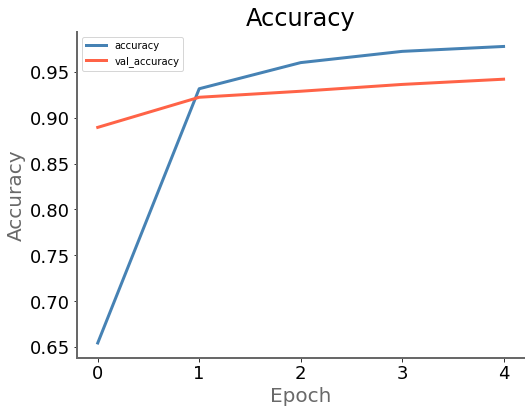

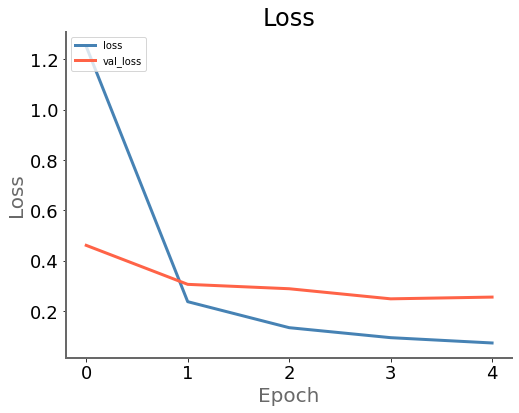

In [13]:
pwk.plot_history(history, save_as='03-history')

## Step 8 - Evaluation and confusion

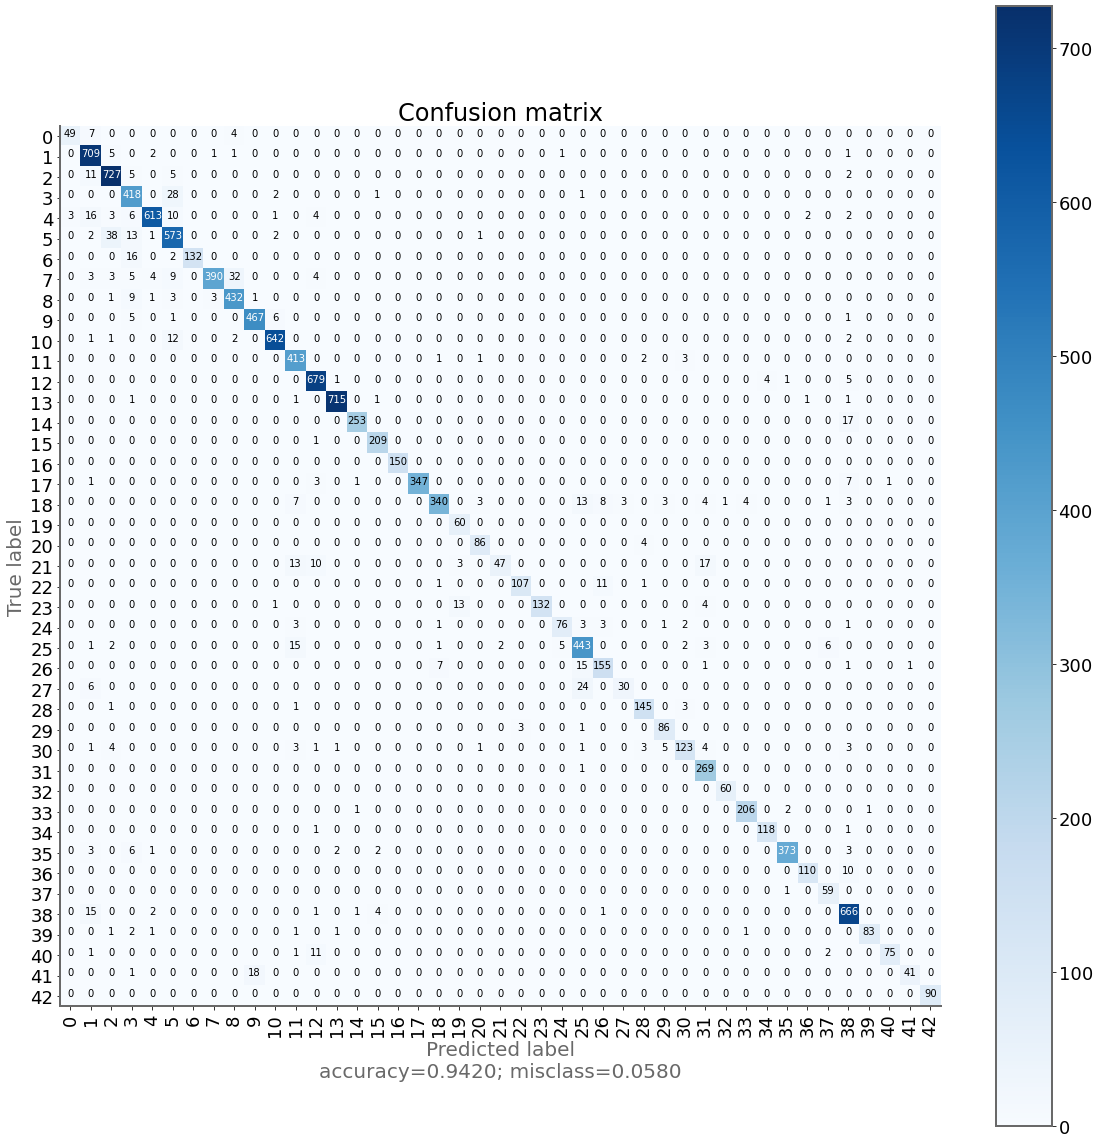

In [14]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

pwk.plot_confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, save_as='04-confusion-matrix')

## Step 9 - Restore and evaluate
### 9.1 - List saved models :

In [15]:
!find "$run_dir"/models/

./run/GTSRB3_done/models/
./run/GTSRB3_done/models/last-model.h5
./run/GTSRB3_done/models/model-0002.h5
./run/GTSRB3_done/models/model-0004.h5
./run/GTSRB3_done/models/best-model.h5
./run/GTSRB3_done/models/model-0005.h5
./run/GTSRB3_done/models/model-0001.h5
./run/GTSRB3_done/models/model-0003.h5


### 9.2 - Restore a model :

In [16]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# loaded_model.summary()
print("Loaded.")

Loaded.


### 9.3 - Evaluate it :

In [17]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2552
Test accuracy  : 0.9420


### 9.4 - Make a prediction :


Output layer from model is (x100) :

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]]

Graphically :



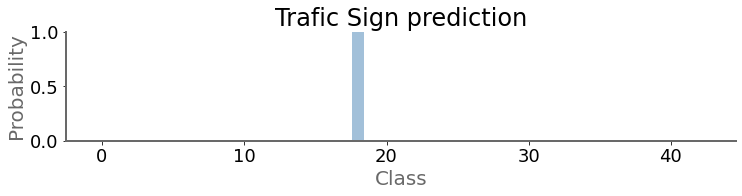


The image :               Prediction :            Real stuff:


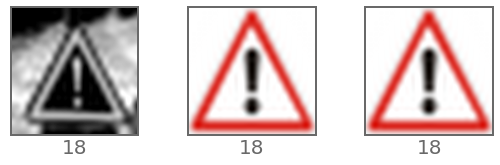

YEEES ! that's right!


In [18]:
# ---- Get a random image
#
i   = random.randint(1,len(x_test))
x,y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = loaded_model.predict( np.array([x]) )

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(43), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))
plt.xlabel('Class')
plt.title('Trafic Sign prediction')
pwk.save_fig('05-prediction-proba')
plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nThe image :               Prediction :            Real stuff:")
pwk.plot_images([x,x_meta[p], x_meta[y]], [p,p,y], range(3),  columns=3,  x_size=3, y_size=2, save_as='06-prediction-images')

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong ;-(")

In [19]:
pwk.end()

End time is : Tuesday 09 February 2021, 18:46:40
Duration is : 00:00:59 273ms
This notebook ends here


<div class="todo">
     What you can do:
    <ul>
        <li>Limit model saving: 1 save every 5 epochs </li>
        <li>Use a subset of the dataset</li>
        <li>Try different datasets</li>
        <li>Some exotic signs are waiting to be recognized in dataset_dir/extra !</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
    </ul>
    
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>